In [48]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# forward AIS
result = np.load('../bayes_implicit_solvent/marginal_likelihood/two_types_radius_and_scale_forward_ais.npz')
#optimized_result = np.load('../bayes_implicit_solvent/marginal_likelihood/single_type_forward_ais_optimized_protocol_longer.npz')

In [49]:
# reverse AIS
reverse_result = np.load('../bayes_implicit_solvent/marginal_likelihood/two_types_radius_and_scale_reverse_ais.npz')
#optimized_reverse_result = np.load('../bayes_implicit_solvent/marginal_likelihood/single_type_reverse_ais_optimized_protocol_longer.npz')

In [50]:
# without protocol optimization
log_weight_trajectories = result['log_weight_trajectories']
reverse_log_weight_trajectories = reverse_result['log_weight_trajectories']

works = - np.array([w[-1] for w in log_weight_trajectories])
reverse_works = - np.array([w[-1] for w in reverse_log_weight_trajectories])

In [51]:
len(works), len(reverse_works)

(1000, 217)

(array([732., 192.,  41.,  17.,   2.,   4.,   6.,   4.,   1.,   1.]),
 array([ 12.12568933,  36.79553372,  61.46537811,  86.13522251,
        110.8050669 , 135.47491129, 160.14475569, 184.81460008,
        209.48444448, 234.15428887, 258.82413326]),
 <a list of 10 Patch objects>)

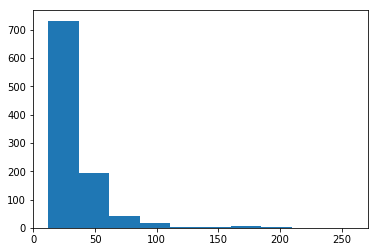

In [43]:
plt.hist(works)

(array([ 4.,  3.,  6., 16., 17., 28., 37., 49., 39., 18.]),
 array([-18.622261, -17.813768, -17.005276, -16.196783, -15.38829 ,
        -14.579798, -13.771305, -12.962812, -12.15432 , -11.345827,
        -10.537334], dtype=float32),
 <a list of 10 Patch objects>)

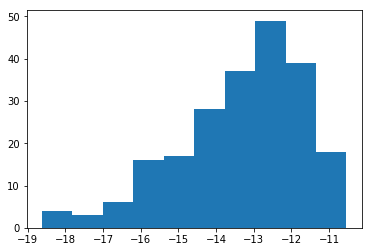

In [44]:
plt.hist(reverse_works)

In [45]:
from pymbar import EXP
DeltaF, dDeltaF = EXP(works)
print(-DeltaF, dDeltaF)

-17.064375110521226 0.26456791927418777


In [46]:
DeltaF, dDeltaF = EXP(reverse_works)
print(DeltaF, dDeltaF)

-15.186323883642157 0.2510038779903425


In [47]:
from pymbar import BAR
DeltaF, dDeltaF = BAR(w_F=works, w_R=reverse_works)
print(-DeltaF, dDeltaF)

-17.129579908421302 0.14578130401756195


In [36]:
one_type_marginal_likelihood = -14.994430572771858
two_types_marginal_likelihood = -DeltaF

In [37]:
bayes_factor = np.exp(two_types_marginal_likelihood - one_type_marginal_likelihood)
bayes_factor

0.11822693356236696

In [54]:
from scipy.stats import norm
np.exp(norm.logcdf(0.01, loc=0.12))

0.4562046874576832

In [38]:
bootstrapped_BAR_estimates = [-BAR(w_F=works[np.random.randint(0,len(works), len(works))],
                                   w_R=reverse_works[np.random.randint(0,len(reverse_works), len(reverse_works))])[0] for _ in tqdm(range(10000))]

100%|██████████| 10000/10000 [00:34<00:00, 285.82it/s]


In [59]:
bootstrapped_BAR_estimates_two_types = bootstrapped_BAR_estimates
bootstrapped_BAR_estimates_one_type = np.load('bootstrapped_bar_long_protocol.npy')

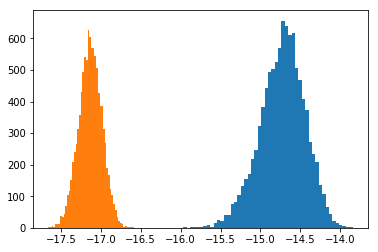

In [61]:
plt.hist(bootstrapped_BAR_estimates_one_type, bins=50);
plt.hist(bootstrapped_BAR_estimates_two_types, bins=50);

In [74]:
prior_location = np.array([0.15, 0.8])
radius_lower_bound = 0.01
scale_lower_bound = 0.1

from scipy.stats import norm
Z_r = (1 - norm.cdf(radius_lower_bound, loc=prior_location[0]))
Z_s = (1 - norm.cdf(scale_lower_bound, loc=prior_location[1]))
log_Z_prior_one_type = np.log((Z_r * Z_s))
log_Z_prior_two_types = np.log((Z_r * Z_s)**2)

In [75]:
# BAR is estimating the difference (log Z_posterior - log Z_prior)
# I actually just want to be looking at the value log Z_posterior
log_marginal_likelihood_one_type = bootstrapped_BAR_estimates_one_type + log_Z_prior_one_type
np.mean(log_marginal_likelihood_one_type)

-15.592890522737545

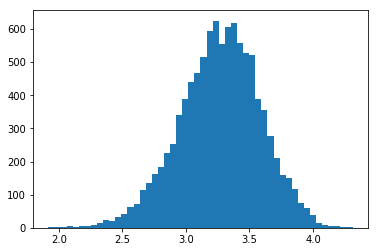

In [82]:
plt.hist((bootstrapped_BAR_estimates_one_type + log_Z_prior_one_type) - (bootstrapped_BAR_estimates_two_types + log_Z_prior_two_types), bins=50);

In [84]:
estimated_DeltaF = np.mean((bootstrapped_BAR_estimates_one_type + log_Z_prior_one_type) - (bootstrapped_BAR_estimates_two_types + log_Z_prior_two_types))
estimated_DeltaF

3.2675044773986506

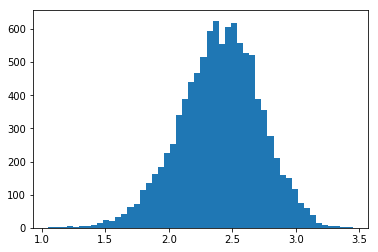

In [63]:
plt.hist(bootstrapped_BAR_estimates_one_type - bootstrapped_BAR_estimates_two_types, bins=50);

Text(0.5, 1.0, 'without applying a bias')

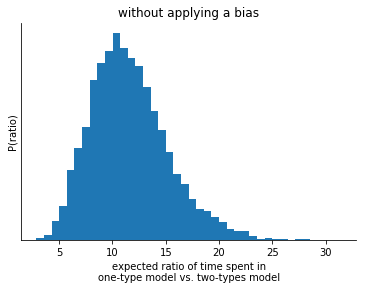

In [86]:
from bayes_implicit_solvent.utils import remove_top_right_spines
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)
plt.hist(np.exp(bootstrapped_BAR_estimates_one_type - bootstrapped_BAR_estimates_two_types), bins=40);
plt.xlabel('expected ratio of time spent in\none-type model vs. two-types model')
plt.ylabel('P(ratio)')
plt.yticks([])

plt.title('without applying a bias')

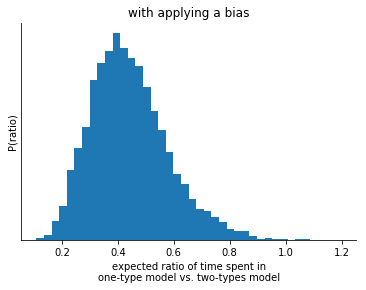

In [98]:
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)
plt.hist(np.exp(bootstrapped_BAR_estimates_one_type - bootstrapped_BAR_estimates_two_types - estimated_DeltaF), bins=40);
plt.xlabel('expected ratio of time spent in\none-type model vs. two-types model')
plt.ylabel('P(ratio)')
plt.yticks([])

plt.title('with applying a bias')
plt.savefig('expected_ratio.png', dpi=300)

Text(0.5, 1.0, 'with applying a bias')

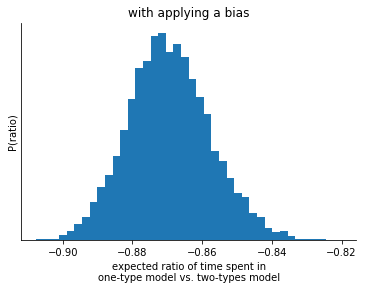

In [97]:
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)

expected_time_spent_in_model_one = bootstrapped_BAR_estimates_one_type
expected_time_spent_in_model_two = bootstrapped_BAR_estimates_two_types - estimated_DeltaF


plt.hist(np.log(expected_time_spent_in_model_one / (expected_time_spent_in_model_one + expected_time_spent_in_model_two)), bins=40);
plt.xlabel('expected ratio of time spent in\none-type model vs. two-types model')
plt.ylabel('P(ratio)')
plt.yticks([])

plt.title('with applying a bias')

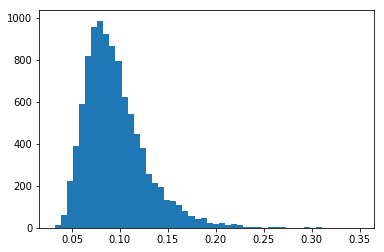

In [66]:
plt.hist(np.exp(-(bootstrapped_BAR_estimates_one_type - bootstrapped_BAR_estimates_two_types)), bins=50);

Text(0.5, 1.0, 'two-types marginal likelihood estimate')

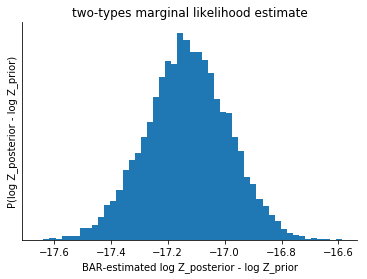

In [91]:
from bayes_implicit_solvent.utils import remove_top_right_spines
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)
plt.hist(bootstrapped_BAR_estimates, bins=50, density=True);
plt.xlabel('BAR-estimated log Z_posterior - log Z_prior')
plt.ylabel('P(log Z_posterior - log Z_prior)')
plt.yticks([])
plt.title('two-types marginal likelihood estimate')

In [ ]:
# with protocol optimization
optimized_log_weight_trajectories = optimized_result['log_weight_trajectories']
optimized_reverse_log_weight_trajectories = optimized_reverse_result['log_weight_trajectories']

optimized_works = - np.array([w[-1] for w in optimized_log_weight_trajectories])
optimized_reverse_works = - np.array([w[-1] for w in optimized_reverse_log_weight_trajectories])

In [ ]:
plt.hist(log_weight_trajectories[:,-1], bins=50, density=True, label='short, unoptimized (n={})'.format(len(log_weight_trajectories)), alpha=0.5);
plt.hist(optimized_log_weight_trajectories[:,-1], density=True, label='long, optimized (n={})'.format(len(optimized_log_weight_trajectories)), alpha=0.5);
plt.legend()

plt.title('forward AIS log-weight distributions')

In [ ]:
plt.hist(reverse_log_weight_trajectories[:,-1], bins=50, density=True, label='short, unoptimized (n={})'.format(len(reverse_log_weight_trajectories)), alpha=0.5);
plt.hist(optimized_reverse_log_weight_trajectories[:,-1], density=True, label='long, optimized (n={})'.format(len(optimized_reverse_log_weight_trajectories)), alpha=0.5);
plt.legend()

plt.title('reverse AIS log-weight distributions');

plt.xlabel('reverse AIS log-weight')
plt.ylabel('P(log-weight)')
plt.yticks([])

In [ ]:
len(optimized_reverse_works), len(optimized_works)

In [ ]:
optimized_bootstrapped_BAR_estimates = [-BAR(w_F=optimized_works[np.random.randint(0,len(optimized_works), len(optimized_works))],
                                   w_R=optimized_reverse_works[np.random.randint(0,len(optimized_reverse_works), len(optimized_reverse_works))])[0] for _ in tqdm(range(10000))]

In [ ]:
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)
plt.hist(bootstrapped_BAR_estimates, bins=50, density=True,
         label='short, unoptimized (n_F={}, n_R={})'.format(len(works), len(reverse_works)),
         alpha=0.5);
plt.hist(optimized_bootstrapped_BAR_estimates, bins=50, density=True,
         label='long, optimized (n_F={}, n_R={})'.format(len(optimized_works), len(optimized_reverse_works)),
         alpha=0.5);
plt.xlabel('BAR-estimated log Z_posterior - log Z_prior')
plt.ylabel('P(log Z_posterior - log Z_prior)')
plt.yticks([])
plt.title('single-type marginal likelihood estimates')
plt.legend(loc='center left')

In [ ]:
trajectories= result['trajectories']
log_weight_trajectories = result['log_weight_trajectories']

In [ ]:
log_weight_trajectories.shape

In [ ]:
plt.hist(log_weight_trajectories[:,99], bins=50);

In [ ]:
len(trajectories)

In [ ]:
plt.plot(log_weight_trajectories.T);

In [ ]:
plt.plot(np.diff(log_weight_trajectories.T, axis=0));

In [ ]:
plt.plot(np.mean(np.diff(log_weight_trajectories.T, axis=0), 1));

In [ ]:
plt.plot(np.std(np.diff(log_weight_trajectories.T, axis=0), 1));

In [ ]:
plt.plot(np.mean(np.diff(optimized_log_weight_trajectories.T, axis=0), 1));

In [ ]:
plt.plot(np.std(np.diff(optimized_log_weight_trajectories.T, axis=0), 1));

In [ ]:
bootstrapped_BAR_estimates

In [ ]:
def resample(array):
    return array[np.random.randint(0,len(array),len(array))]

In [ ]:
from pymbar import EXP
bootstrapped_forward_exp_estimates = -np.array([EXP(resample(works))[0] for _ in tqdm(range(10000))])
bootstrapped_reverse_exp_estimates = -np.array([EXP(resample(reverse_works))[0] for _ in tqdm(range(10000))])


In [ ]:
plt.hist(bootstrapped_forward_exp_estimates, bins=50);

In [ ]:
EXP(-reverse_works)

In [ ]:
for _ in range(20):
    i = np.random.randint(len(trajectories))
    plt.plot(*trajectories[i].T)

In [39]:
posterior_sampling_result = np.load('../bayes_implicit_solvent/marginal_likelihood/two_types_posterior_samples.npz')

In [40]:
log_prob_traj = posterior_sampling_result['log_probs']

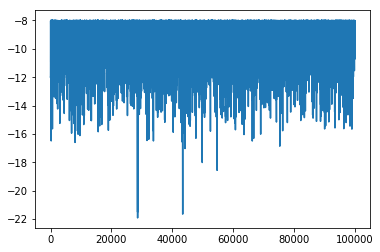

In [41]:
plt.plot(log_prob_traj)

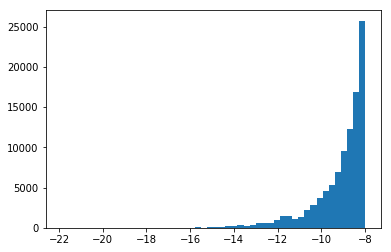

In [42]:
plt.hist(posterior_sampling_result['log_probs'], bins=50);

In [43]:
traj = posterior_sampling_result['traj']

In [44]:
traj.shape

(100001, 2)

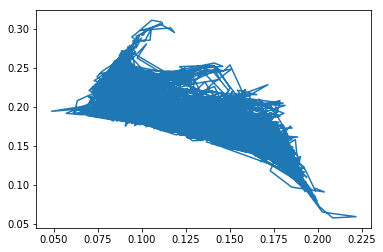

In [45]:
plt.plot(*traj.T)

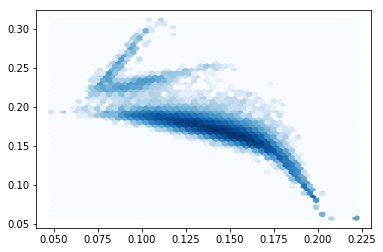

In [46]:
plt.hexbin(*traj.T, cmap='Blues', bins='log', gridsize=50);

In [ ]:
posterior_sampling_result['acceptance_probability']

In [2]:
# evaluate on a grid

from bayes_implicit_solvent.marginal_likelihood.two_types_forward_ais import log_likelihood

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:167: UserWarning: No GPU found, falling back to CPU.
  warnings.warn('No GPU found, falling back to CPU.')


ethane
benzene
cyclopentane
ethylene
methane
cyclopropane
cyclohexane


In [19]:
import numpy as np
log_likelihood(np.ones(2))
grid_density = 200
r_H_grid = np.linspace(0.05, 0.3, grid_density)
r_C_grid = np.linspace(0.05, 0.3, grid_density)
LL_grid = np.zeros((grid_density, grid_density))

from tqdm import tqdm
for i in tqdm(range(len(r_H_grid))):
    for j in range(len(r_C_grid)):
        theta = np.array((r_H_grid[i], r_C_grid[j]))
        LL_grid[i,j] = log_likelihood(theta)

100%|██████████| 200/200 [01:06<00:00,  3.40it/s]


Text(0, 0.5, 'C radius (A)')

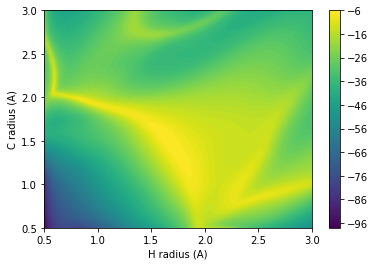

In [48]:
plt.contourf(r_H_grid * 10, r_C_grid * 10, LL_grid, levels=100)
plt.colorbar()
plt.xlabel('H radius (A)')
plt.ylabel('C radius (A)')

Text(0, 0.5, 'C radius (A)')

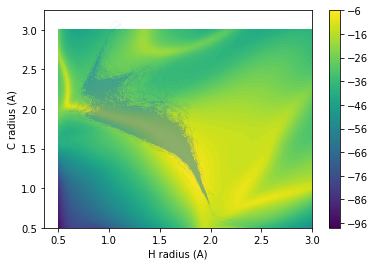

In [51]:
plt.contourf(r_H_grid * 10, r_C_grid * 10, LL_grid, levels=100)
plt.plot(*(traj.T * 10), alpha=0.5, linewidth=0.1)
plt.colorbar()
plt.xlabel('H radius (A)')
plt.ylabel('C radius (A)')

Text(0, 0.5, 'C radius (A)')

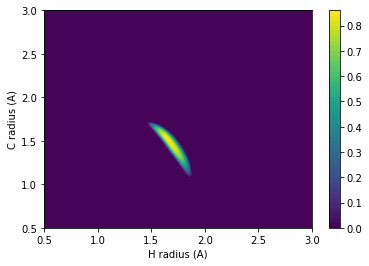

In [33]:
plt.contourf(r_H_grid * 10, r_C_grid * 10, (LL_grid + 7) * (LL_grid > -7), levels=50)
plt.colorbar()
plt.xlabel('H radius (A)')
plt.ylabel('C radius (A)')